Попытка использования генетического алгоритма

In [42]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [44]:
df = pd.read_csv(r'C:\Users\Ксения\Project\Megy\content\Distr_data_0202_last.csv')

In [45]:
X = df.drop(columns=['Remanence_magnetization', 'Coercivity'])
y = df[['Remanence_magnetization', 'Coercivity']]

In [46]:
# Функция для оценки приспособленности модели
def fitness_function(y_true, y_pred):
    return -mean_squared_error(y_true, y_pred)  # Минимизируем MSE, поэтому используем отрицательное значение

# Функция для создания начальной популяции
def initialize_population(pop_size, n_features):
    population = []
    for _ in range(pop_size):
        chromosome = np.random.randint(2, size=n_features)  # Генерируем случайный бинарный вектор длиной n_features
        population.append(chromosome)
    return np.array(population)

# Функция для преобразования хромосомы в параметры модели
def decode_chromosome(chromosome):
    selected_features = [bool(bit) for bit in chromosome]
    return X.iloc[:, selected_features]

# Функция для оценки приспособленности каждого индивида в популяции
def evaluate_population(population):
    fitness_scores = []
    for chromosome in population:
        X_selected = decode_chromosome(chromosome)
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fitness = fitness_function(y_test, y_pred)
        fitness_scores.append(fitness)
    return np.array(fitness_scores)

# Функция для выбора лучших индивидуумов для скрещивания
def select_parents(population, fitness_scores, num_parents):
    selected_indices = np.argsort(fitness_scores)[-num_parents:]  # Выбираем лучшие индивидуумы
    return population[selected_indices]

# Функция для скрещивания (одноточечный кроссовер)
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    offspring_size = (max(offspring_size[0], 0), max(offspring_size[1], 0))  # Убедимся, что размеры неотрицательные
    crossover_point = np.random.randint(1, offspring_size[1])  # Случайная точка для скрещивания
    for i in range(offspring_size[0]):
        # Выбор двух родителей для скрещивания
        parent1_idx = i % parents.shape[0]
        parent2_idx = (i+1) % parents.shape[0]
        # Скрещивание генов
        offspring[i, :crossover_point] = parents[parent1_idx, :crossover_point]
        offspring[i, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

# Функция для мутации
def mutate(offspring):
    mutation_rate = 0.1  # Вероятность мутации
    for i in range(offspring.shape[0]):
        for j in range(offspring.shape[1]):
            if np.random.rand() < mutation_rate:
                offspring[i, j] = 1 - offspring[i, j]  # Инвертируем бит
    return offspring

In [47]:
# Основной цикл генетического алгоритма
population_size = 10
num_generations = 100
num_parents = 20
num_features = X.shape[1]
population = initialize_population(population_size, num_features)

for generation in range(num_generations):
    fitness_scores = evaluate_population(population)
    parents = select_parents(population, fitness_scores, num_parents)
    offspring_crossover = crossover(parents, offspring_size=(population_size-num_parents, num_features))
    offspring_mutation = mutate(offspring_crossover)
    population[0:num_parents, :] = parents
    population[num_parents:, :] = offspring_mutation

# Выбор лучшей хромосомы (на основе наибольшего значения приспособленности)
best_chromosome = population[np.argmax(fitness_scores)]
selected_features = decode_chromosome(best_chromosome)

# Подготовка и обучение модели на выбранных признаках
X_train_selected, X_test_selected, y_train, y_test = train_test_split(selected_features, y, test_size=0.2, random_state=42)
model = RandomForestRegressor()
model.fit(X_train_selected, y_train)

# Оценка модели
y_pred = model.predict(X_test_selected)
fitness = fitness_function(y_test, y_pred)
print("Fitness (MSE) на тестовом наборе данных:", fitness)

ValueError: negative dimensions are not allowed

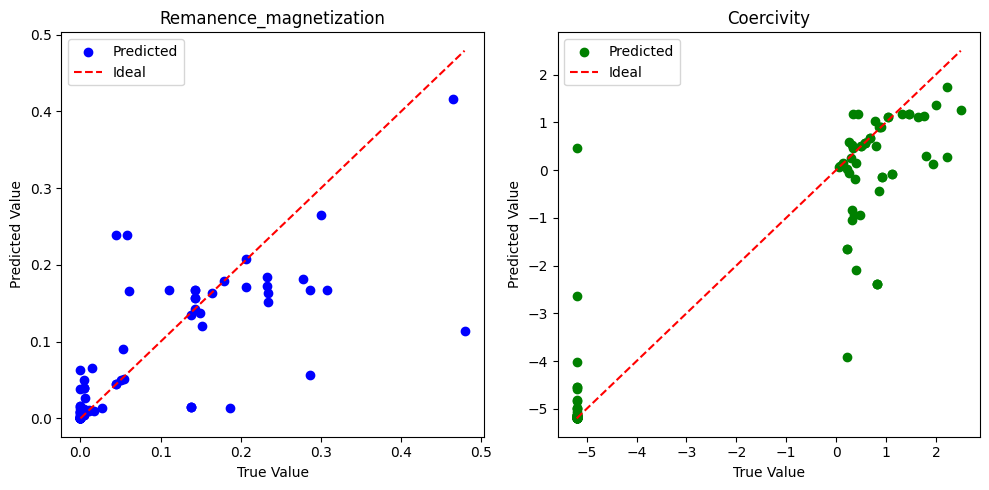

In [ ]:
import matplotlib.pyplot as plt

# Визуализация реальных и предсказанных значений целевых переменных
plt.figure(figsize=(10, 5))

# Визуализация Remanence_magnetization
plt.subplot(1, 2, 1)
plt.scatter(y_test['Remanence_magnetization'], y_pred[:, 0], color='blue', label='Predicted')
plt.plot([min(y_test['Remanence_magnetization']), max(y_test['Remanence_magnetization'])],
         [min(y_test['Remanence_magnetization']), max(y_test['Remanence_magnetization'])],
         color='red', linestyle='--', label='Ideal')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Remanence_magnetization')
plt.legend()

# Визуализация Coercivity
plt.subplot(1, 2, 2)
plt.scatter(y_test['Coercivity'], y_pred[:, 1], color='green', label='Predicted')
plt.plot([min(y_test['Coercivity']), max(y_test['Coercivity'])],
         [min(y_test['Coercivity']), max(y_test['Coercivity'])],
         color='red', linestyle='--', label='Ideal')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Coercivity')
plt.legend()

plt.tight_layout()
plt.show()